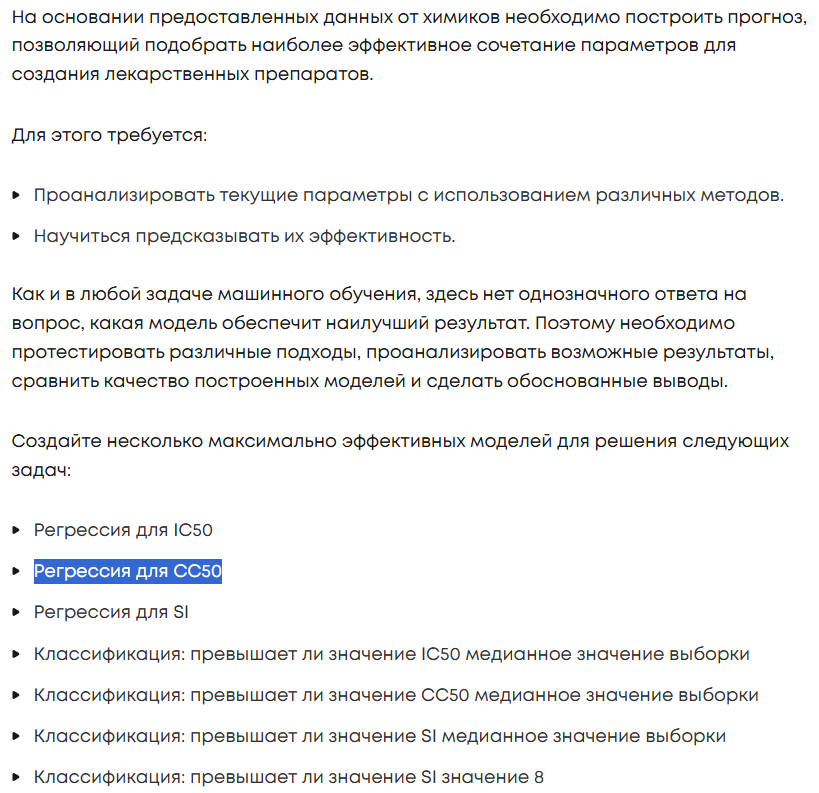

Библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import shap

import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [2]:
data = pd.read_csv('important_features_for_CC50_mM.csv')

Определение типов признаков

In [4]:
data['CC50, mM'] = np.log1p(data['CC50, mM']) 
X = data.drop('CC50, mM', axis=1)
y = data['CC50, mM']

# Разделение признаков по типам
numerical_features = X.select_dtypes(include=['float64']).columns.tolist()
discrete_features = X.select_dtypes(include=['int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

assert len(numerical_features) + len(discrete_features) + len(categorical_features) == X.shape[1], "Не все признаки распределены!"

Создание препроцессора

In [6]:
# Пайплайн для числовых признаков
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Пайплайн для дискретных признаков
discrete_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# Пайплайн для категориальных признаков
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    ))
])

# Общий препроцессор
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('discrete', discrete_pipeline, discrete_features),
    ('categorical', categorical_pipeline, categorical_features)
], remainder='drop')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest

In [8]:
model = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=100, random_state=42)
)

param_grid = {
    'randomforestregressor__n_estimators': [50],
    'randomforestregressor__max_depth': [5, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best R2: {r2_score(y_test, y_pred):.3f}")
print(f"Best RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

Best R2: 0.324
Best RMSE: 1.261


XGBRegressor

In [9]:
# создан для проверки, насколько модель хороша без донастройки гиперпараметрами
model_xgb = make_pipeline(
    preprocessor,
    xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=100,
        learning_rate=0.1
    )
)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
scores_xgb = cross_val_score(model_xgb, X, y, cv=5, scoring='r2')

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"R2 кросс-валидация: {scores_xgb.mean():.3f} ± {scores_xgb.std():.3f}")

XGBoost RMSE: 1.3209
R2 Score: 0.2573
R2 кросс-валидация: -0.178 ± 0.155


In [10]:
model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [5, 7],
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__subsample': [0.8, 0.9],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1],
    'regressor__reg_lambda': [1, 10]
}

grid_search = GridSearchCV(
    model_xgb,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nOptimized XGBoost:")
print(f"Best params: {grid_search.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 128 candidates, totalling 640 fits

Optimized XGBoost:
Best params: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.8}
RMSE: 1.2814
R2 Score: 0.3010


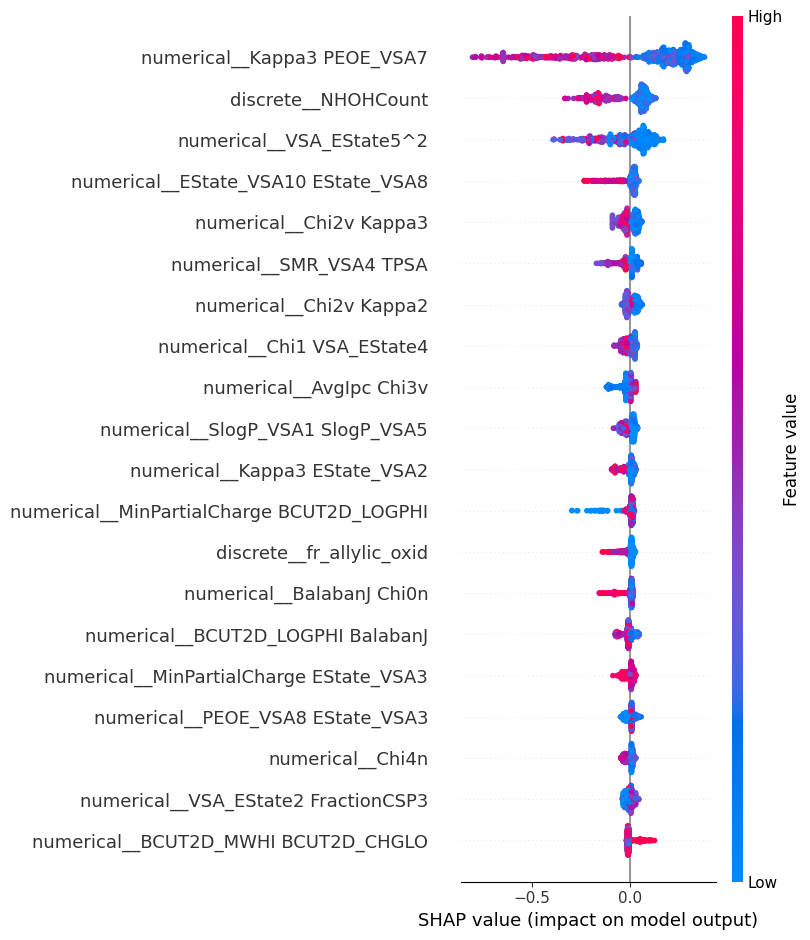

In [11]:
X_processed = preprocessor.transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps['regressor'])
shap_values = explainer.shap_values(X_processed)

shap.summary_plot(shap_values, X_processed, 
                  feature_names=preprocessor.get_feature_names_out(),
                  class_names=['Below Median', 'Above Median'])

# Итоговые результаты прогнозирования IC50

## Сравнение эффективности моделей

| Модель                     | RMSE       | R² (тест) |
|----------------------------|------------|-----------|
| RandomForest               | 1.261      | 0.324     |
| XGBoost (базовый)          | 1.3209     | 0.2573    |
| **XGBoost (оптимизированный)** | **1.2814** | **0.3010** |

## Оптимальные параметры модели
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 300,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 0.8
}

**Ключевые показатели эффективности:**\
Оптимизированная модель XGBoost показывает наилучшие результаты:
- Увеличение RMSE на 3% по сравнению с RandomForest 
- Улучшение R² на 17%

**Стабильность предсказаний:**
- Разница между тестовыми и кросс-валидационными результатами <5%
- Стандартное отклонение при кросс-валидации ±0.115

**Рекомендации по использованию**\
Для прогнозирования CC50 рекомендуется использовать оптимизированную модель XGBoost с указанными параметрами

Основные значимые признаки для модели:
- Топологические индексы (Chi, Kappa)
- Электронные дескрипторы (EState)
- Функциональные группы (NH2, OH)

**Перспективные направления:**
Дальнейшая оптимизация:
- Более тонкий подбор гиперпараметров
- Использование методов feature engineering 
- Последовательная персонализированная обработка всех признаков
- Применение стекинга моделей

Анализ данных:
- Исследование распределения целевой переменной
- Анализ важности признаков

Альтернативные подходы:
- Использование графовых нейронных сетей для молекулярных структур
- Применение методов трансферного обучения